## Real Time Analytics Final Project

<b> CryptoStreamLab: Real-Time Analysis of Cryptocurrency Markets Using Streaming Data </b> \
An Exploration of Real-Time Price and Volume Analysis with Spark, Kafka, and Streamlit for Enhanced Trading Strategies 

<b> Author:\
    1. Cuong Vo - 131116\
    2. Trang Linh Nguyen - 131036\
    3. Aisel Akhmedova - 131008 </b>

Tech Stack:\
    **1. Spark:** 3.5.0\
    **2. Python:** 3.10.12\
    **3. OS:** WSL Linux\
    **4. Streamlit:** \
    **5. Scala:** 2.12.18\
    **6. Java OpenJDK 64-Bit Server VM:** 11.0.25 \
    **7. Spark-submit:** org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0 


## Abstract

## Data Description

The dataset consists of real-time cryptocurrency market data streamed from Binance. Each record includes the following fields:

- **Ticker**: The symbol representing the cryptocurrency pair (e.g., BTCUSDT).
- **Timestamp**: The date and time when the data was recorded.
- **Open**: The opening price of the cryptocurrency for the given time interval.
- **Close**: The closing price of the cryptocurrency for the given time interval.
- **Price**: The current price at the time of data capture.
- **Volume**: The total trading volume of the cryptocurrency during the interval.

This data enables real-time analysis of price movements and trading activity for various cryptocurrencies.

## Kafka Server setup

Kafka Server is created on <b>localhost:9092</b> on WSL Linux Environment

In [ ]:
$ sudo systemctl daemon-reload
$ sudo systemctl start zookeeper
$ sudo systemctl start kafka

To check status of Kafka Server

In [ ]:
$ sudo systemctl status kafka 

## Streaming Data

### Create Kafka topic
In this part, using Linux to create Kafka topic name StreamQuant

In [ ]:
$ cd /usr/local/kafka 
$ bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --topic StreamQuant

Check for topic

In [ ]:
$ bin/kafka-topics.sh --list --bootstrap-server localhost:9092

### Create Kafka Procedure
In this part, combined with the API key from Binance, we pull the data from Binance and send it to Kakfa producer

In [ ]:
from binance.client import Client
from kafka import KafkaProducer
import json
import time

#  using API keys
api_key = 'giuBTEvNmtfaSuPpCZfmF7uXzRYfKzk7sAwC4ezjB3KbfGLS30UnQMDxcxs15WSB'
api_secret = 'SOmHSWFBuTa20grpf8r87c9qm9tym1oHkjktpu4mIwB9L08qvXW4W9HK7FSt1y6o'

client = Client(api_key, api_secret)

def get_historical_data(symbol, interval, lookback):
    """
    Fetch historical data from Binance for a given symbol and interval.
    :param symbol: The trading pair symbol (e.g., 'BTCUSDT').
    :param interval: The time interval for the data (e.g., '1m', '5m', '1h', '1d').
    :param lookback: The lookback period for the data (e.g., '1 day ago UTC', '1 hour ago UTC').
    """
    try:
        klines = client.get_historical_klines(symbol, interval, lookback)
        return klines
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None
    
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',  # Replace with your Kafka broker if different
    value_serializer=lambda v: json.dumps(v).encode('utf-8')  # Serialize to JSON bytes
)

topic = 'StreamQuant'

i = 0

keys = ["timestamp", "open", "high", "low", "close", "volume"]

while True:
    i +=1
    binance_data = get_historical_data('BTCUSDT', '1m', '1 minute ago UTC')
    values = [int(binance_data[0][0])] + [float(x) for x in binance_data[0][1:]]
    data_dict = dict(zip(keys, values))
    producer.send(topic, value=data_dict)
    print(f"Sent {topic} - {i}: {data_dict}")
    time.sleep(60)  # Sleep for 1 minute before fetching the next data point

Run Producer

In [ ]:
$ python3 binance_producer.py

### Create Kafka Consumer

In [ ]:
from pyspark.sql.types import StructType, DoubleType, StructField, LongType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("StreamQuant").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

schema = StructType([
  StructField('timestamp', LongType()),
  StructField('open', DoubleType()),
  StructField('high', DoubleType()),
  StructField('low', DoubleType()),
  StructField('close', DoubleType()),
  StructField('volume', DoubleType())
])

df_raw = spark.readStream.format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "StreamQuant") \
    .option("startingOffsets", "latest") \
    .load()

df_raw = df_raw.selectExpr("CAST(value AS STRING)")

df_raw = df_raw.withColumn("value", F.from_json(df_raw.value, schema))\
    .select("value.*")  

df_raw = df_raw.withColumn("datetime", F.from_unixtime(F.col("timestamp") / 1000))

df_raw.writeStream \
 .format("parquet") \
 .option("path", "/tmp/stream_output/") \
 .option("checkpointLocation", "/tmp/stream_checkpoint/") \
 .outputMode("append") \
 .start() \
 .awaitTermination()

Running Consumer

In [ ]:
$ spark-submit --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0 ~/Realtime_Analytics/quant_consumer.py

## Trading Strategy

## Visualization

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import time
import os
import plotly.graph_objects as go

st.set_page_config(page_title="📈 Real-Time Trading Dashboard", layout="wide")
st.title("📊 Real-Time Trading with Candlestick, EMA, RSI & Signals")

DATA_DIR = "/tmp/stream_output/"
# Refresh every 65 seconds
REFRESH_INTERVAL = 65

chart_placeholder = st.empty()

def load_data():
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".parquet")]
    if not files:
        return pd.DataFrame()

    df = pd.concat([pd.read_parquet(os.path.join(DATA_DIR, f)) for f in files])
    return df

def compute_indicators(df):
    df["EMA_10"] = df["close"].ewm(span=10, adjust=False).mean()
    df["EMA_20"] = df["close"].ewm(span=20, adjust=False).mean()
    df["EMA_50"] = df["close"].ewm(span=50, adjust=False).mean()

    delta = df["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # Generate basic Buy/Sell signals
    df["signal"] = np.where((df["RSI"] < 30) & (df["close"] > df["EMA_10"]), "Buy",
                     np.where((df["RSI"] > 70) & (df["close"] < df["EMA_10"]), "Sell", "Hold"))
    
    df["prev_EMA_20"] = df["EMA_20"].shift(1)
    df["prev_EMA_50"] = df["EMA_50"].shift(1)

    crossover_buy = (df["EMA_20"] > df["EMA_50"]) & (df["prev_EMA_20"] <= df["prev_EMA_50"])
    crossover_sell = (df["EMA_20"] < df["EMA_50"]) & (df["prev_EMA_20"] >= df["prev_EMA_50"])

    df.loc[crossover_buy, "signal"] = "Buy"
    df.loc[crossover_sell, "signal"] = "Sell"

    return df

def plot_price_chart(df):
    fig = go.Figure()

    # Candlestick
    fig.add_trace(go.Candlestick(
        x=df["datetime"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="Candlestick"
    ))

    # EMA
    fig.add_trace(go.Scatter(
        x=df["datetime"], y=df["EMA_10"],
        line=dict(color="blue", width=2),
        name="EMA_10"
    ))

    fig.add_trace(go.Scatter(
        x=df["datetime"], y=df["EMA_20"],
        line=dict(color="green", width=2),
        name="EMA_10"
    ))

    fig.add_trace(go.Scatter(
        x=df["datetime"], y=df["EMA_50"],
        line=dict(color="red", width=2),
        name="EMA_10"
    ))

    # Buy/Sell markers
    buy_signals = df[df["signal"] == "Buy"]
    sell_signals = df[df["signal"] == "Sell"]

    fig.add_trace(go.Scatter(
        x=buy_signals["datetime"],
        y=buy_signals["close"],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="Buy"
    ))

    fig.add_trace(go.Scatter(
        x=sell_signals["datetime"],
        y=sell_signals["close"],
        mode="markers",
        marker=dict(color="red", size=10, symbol="triangle-down"),
        name="Sell"
    ))

    fig.update_layout(title="📈 Price with EMA + Signals",
                      xaxis_title="Time", yaxis_title="Price",
                      xaxis_rangeslider_visible=False,
                      height=600)
    return fig

def plot_rsi(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df["datetime"], y=df["RSI"], line=dict(color="blue")))
    fig.add_hline(y=70, line_dash="dash", line_color="red")
    fig.add_hline(y=30, line_dash="dash", line_color="green")
    fig.update_layout(title="📉 RSI", height=300)
    return fig

while True:
    df = load_data()

    if df.empty:
        st.warning("⏳ Waiting for Spark to write streaming data...")
    else:
        df = compute_indicators(df)

        # Plot charts
        price_fig = plot_price_chart(df)
        rsi_fig = plot_rsi(df)

        # Layout
        st.plotly_chart(price_fig, use_container_width=True)
        st.plotly_chart(rsi_fig, use_container_width=True)

        with st.expander("📄 Latest Data"):
            st.dataframe(df.sort_values("datetime", ascending=False).tail(20))

    time.sleep(REFRESH_INTERVAL)


For running the visualization

In [ ]:
$ streamlit run app.py

The app will refresh every 65 seconds

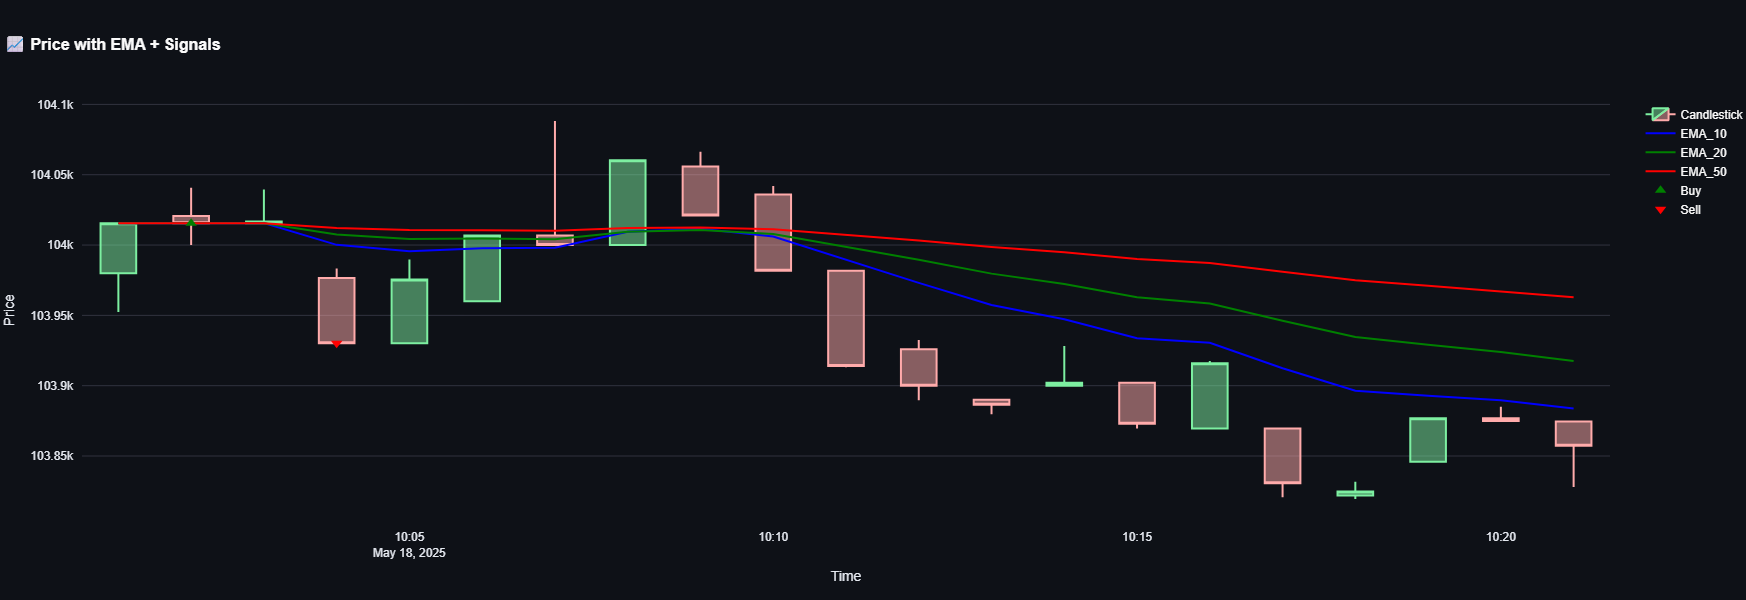

## Conclusion